In [3]:
import pandas as pd
import numpy as np
from keras.layers import Dense, LSTM
import matplotlib.pyplot as plt
import tensorflow as tf

In [4]:
df = pd.read_csv('/content/energydata.csv')
df.head()

,date,Appliances,lights,T1,RH_1,T2,RH_2,T3,RH_3,T4,RH_4,T5,RH_5,T6,RH_6,T7,RH_7,T8,RH_8,T9,RH_9,T_out,Press_mm_hg,RH_out,Windspeed,Visibility,Tdewpoint,rv1,rv2
0,1/11/2016 17:00,60,30,19.89,47.596667,19.2,44.790000,19.79,44.730000,19.000000,45.566667,17.166667,55.20,7.026667,84.256667,17.200000,41.626667,18.2,48.900000,17.033333,45.53,6.60,733.5,92.0,7.000000,63.000000,5.3,13.275433,13.275433
1,1/11/2016 17:10,60,30,19.89,46.693333,19.2,44.722500,19.79,44.790000,19.000000,45.992500,17.166667,55.20,6.833333,84.063333,17.200000,41.560000,18.2,48.863333,17.066667,45.56,6.48,733.6,92.0,6.666667,59.166667,5.2,18.606195,18.606195
2,1/11/2016 17:20,50,30,19.89,46.300000,19.2,44.626667,19.79,44.933333,18.926667,45.890000,17.166667,55.09,6.560000,83.156667,17.200000,41.433333,18.2,48.730000,17.000000,45.50,6.37,733.7,92.0,6.333333,55.333333,5.1,28.642668,28.642668
3,1/11/2016 17:30,50,40,19.89,46.066667,19.2,44.590000,19.79,45.000000,18.890000,45.723333,17.166667,55.09,6.433333,83.423333,17.133333,41.290000,18.1,48.590000,17.000000,45.40,6.25,733.8,92.0,6.000000,51.500000,5.0,45.410390,45.410390
4,1/11/2016 17:40,60,40,19.89,46.333333,19.2,44.530000,19.79,45.000000,18.890000,45.530000,17.200000,55.09,6.366667,84.893333,17.200000,41.230000,18.1,48.590000,17.000000,45.40,6.13,733.9,92.0,5.666667,47.666667,4.9,10.084097,10.084097


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19735 entries, 0 to 19734
Data columns (total 29 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   date         19735 non-null  object 
 1   Appliances   19735 non-null  int64  
 2   lights       19735 non-null  int64  
 3   T1           19735 non-null  float64
 4   RH_1         19735 non-null  float64
 5   T2           19735 non-null  float64
 6   RH_2         19735 non-null  float64
 7   T3           19735 non-null  float64
 8   RH_3         19735 non-null  float64
 9   T4           19735 non-null  float64
 10  RH_4         19735 non-null  float64
 11  T5           19735 non-null  float64
 12  RH_5         19735 non-null  float64
 13  T6           19735 non-null  float64
 14  RH_6         19735 non-null  float64
 15  T7           19735 non-null  float64
 16  RH_7         19735 non-null  float64
 17  T8           19735 non-null  float64
 18  RH_8         19735 non-null  float64
 19  T9  

In [6]:
df.isnull().sum()

date           0
Appliances     0
lights         0
T1             0
RH_1           0
T2             0
RH_2           0
T3             0
RH_3           0
T4             0
RH_4           0
T5             0
RH_5           0
T6             0
RH_6           0
T7             0
RH_7           0
T8             0
RH_8           0
T9             0
RH_9           0
T_out          0
Press_mm_hg    0
RH_out         0
Windspeed      0
Visibility     0
Tdewpoint      0
rv1            0
rv2            0
dtype: int64

In [7]:
df['date']=pd.to_datetime(df['date'])
df.set_index('date', inplace=True)

In [8]:
df.head()

,Appliances,lights,T1,RH_1,T2,RH_2,T3,RH_3,T4,RH_4,T5,RH_5,T6,RH_6,T7,RH_7,T8,RH_8,T9,RH_9,T_out,Press_mm_hg,RH_out,Windspeed,Visibility,Tdewpoint,rv1,rv2
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2016-01-11 17:00:00,60,30,19.89,47.596667,19.2,44.790000,19.79,44.730000,19.000000,45.566667,17.166667,55.20,7.026667,84.256667,17.200000,41.626667,18.2,48.900000,17.033333,45.53,6.60,733.5,92.0,7.000000,63.000000,5.3,13.275433,13.275433
2016-01-11 17:10:00,60,30,19.89,46.693333,19.2,44.722500,19.79,44.790000,19.000000,45.992500,17.166667,55.20,6.833333,84.063333,17.200000,41.560000,18.2,48.863333,17.066667,45.56,6.48,733.6,92.0,6.666667,59.166667,5.2,18.606195,18.606195
2016-01-11 17:20:00,50,30,19.89,46.300000,19.2,44.626667,19.79,44.933333,18.926667,45.890000,17.166667,55.09,6.560000,83.156667,17.200000,41.433333,18.2,48.730000,17.000000,45.50,6.37,733.7,92.0,6.333333,55.333333,5.1,28.642668,28.642668
2016-01-11 17:30:00,50,40,19.89,46.066667,19.2,44.590000,19.79,45.000000,18.890000,45.723333,17.166667,55.09,6.433333,83.423333,17.133333,41.290000,18.1,48.590000,17.000000,45.40,6.25,733.8,92.0,6.000000,51.500000,5.0,45.410390,45.410390
2016-01-11 17:40:00,60,40,19.89,46.333333,19.2,44.530000,19.79,45.000000,18.890000,45.530000,17.200000,55.09,6.366667,84.893333,17.200000,41.230000,18.1,48.590000,17.000000,45.40,6.13,733.9,92.0,5.666667,47.666667,4.9,10.084097,10.084097


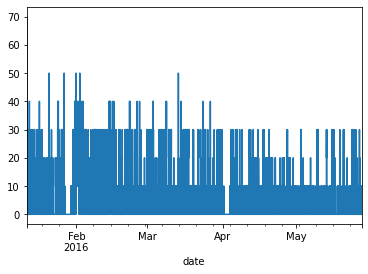

In [9]:
df['lights'].plot()

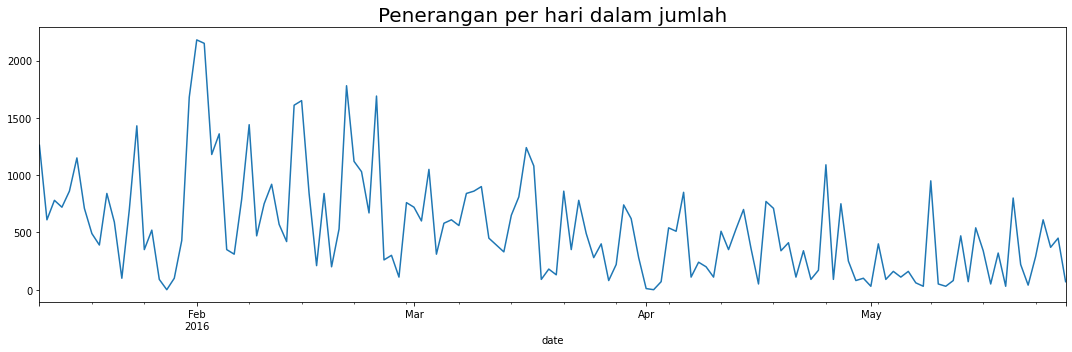

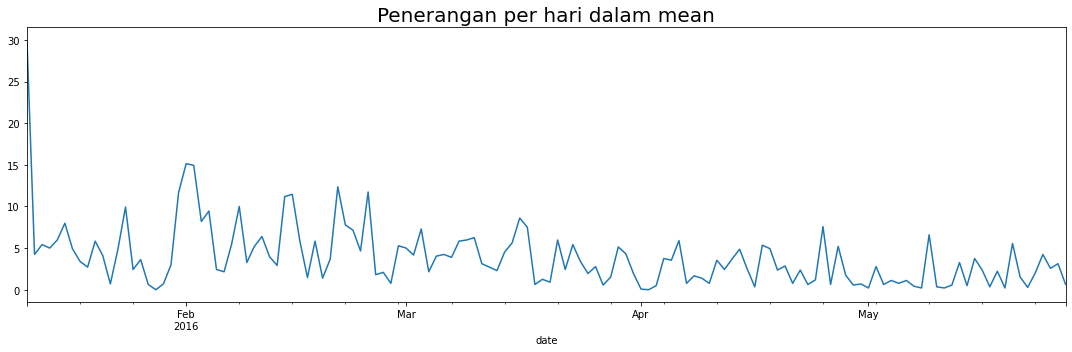

In [10]:
lights = df['lights'].resample('D') #resample per hari

plt.figure(figsize=(15,5))
lights.sum().plot()
plt.title('Penerangan per hari dalam jumlah',fontsize=20)
plt.tight_layout()
plt.show()

plt.figure(figsize=(15,5))
lights.mean().plot()
plt.title('Penerangan per hari dalam mean',fontsize=20)
plt.tight_layout()
plt.show()

In [11]:
#backup
df_new = df

In [12]:
data_resample = df_new.resample('h').mean() #diresample berdasarkan jam
nilai = data_resample.values

In [13]:
df = df.loc['2016-05-01':]
df = df.round(2)

test_days = 2
test_ind = test_days*144
test_ind

split_time = test_ind
data_train = nilai[:split_time,:]
data_test = nilai[split_time:]

In [14]:
from sklearn.preprocessing import MinMaxScaler
scaling = MinMaxScaler(feature_range=(0,1))
scaling.fit(data_train)

test_scaled = scaling.transform(data_train)
train_scaled = scaling.transform(data_test)

In [15]:
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

panjang = 144
batch_size = 1
generator = TimeseriesGenerator(train_scaled, train_scaled, length=panjang, batch_size=batch_size)
val_gen = TimeseriesGenerator(test_scaled, test_scaled, length = panjang, batch_size=batch_size)

In [16]:
X,y = generator[0]

In [17]:
model = tf.keras.Sequential([
                             tf.keras.layers.LSTM(100, input_shape=(panjang,train_scaled.shape[1]),return_sequences=True),
                             tf.keras.layers.Dropout(0.2),
                             tf.keras.layers.LSTM(50),
                             tf.keras.layers.Dropout(0.2),
                             tf.keras.layers.Dense(train_scaled.shape[1])
])
num_epochs = 25


from tensorflow.keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor='val_loss',patience=4)

model.compile(loss = 'mean_squared_error',
              optimizer = 'adam',
              metrics = 'mae')

history = model.fit(generator, epochs = num_epochs, batch_size = 50,
                        validation_data = val_gen,callbacks = [early_stop],
                        verbose = 2)

Epoch 1/25
2858/2858 - 279s - loss: 0.0429 - mae: 0.1530 - val_loss: 0.0243 - val_mae: 0.1195
Epoch 2/25
2858/2858 - 277s - loss: 0.0216 - mae: 0.1111 - val_loss: 0.0203 - val_mae: 0.1081
Epoch 3/25
2858/2858 - 276s - loss: 0.0184 - mae: 0.1014 - val_loss: 0.0168 - val_mae: 0.0959
Epoch 4/25
2858/2858 - 270s - loss: 0.0164 - mae: 0.0953 - val_loss: 0.0231 - val_mae: 0.1191
Epoch 5/25
2858/2858 - 275s - loss: 0.0152 - mae: 0.0910 - val_loss: 0.0163 - val_mae: 0.0943
Epoch 6/25
2858/2858 - 273s - loss: 0.0140 - mae: 0.0876 - val_loss: 0.0176 - val_mae: 0.1009
Epoch 7/25
2858/2858 - 276s - loss: 0.0134 - mae: 0.0853 - val_loss: 0.0143 - val_mae: 0.0891
Epoch 8/25
2858/2858 - 279s - loss: 0.0131 - mae: 0.0842 - val_loss: 0.0132 - val_mae: 0.0873
Epoch 9/25
2858/2858 - 283s - loss: 0.0128 - mae: 0.0832 - val_loss: 0.0204 - val_mae: 0.1126
Epoch 10/25
2858/2858 - 277s - loss: 0.0125 - mae: 0.0822 - val_loss: 0.0181 - val_mae: 0.1039
Epoch 11/25
2858/2858 - 275s - loss: 0.0122 - mae: 0.0812 -

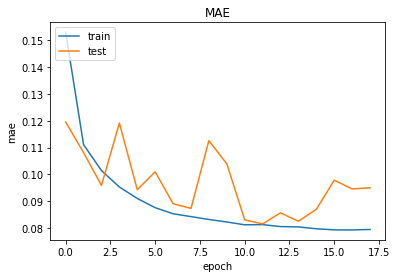

In [18]:
import matplotlib.pyplot as plt
plt.plot(history.history['mae'])
plt.plot(history.history['val_mae'])
plt.title('MAE')
plt.ylabel('mae')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()